<a href="https://colab.research.google.com/github/It21258794/DL_Assignment_SE4050/blob/main/Copy_of_LSTM_Fligth_Delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
# Define the path to the data set
path = "/content/drive/MyDrive/flights_sample_3m.csv.zip"

In [ ]:
# importing the dataset
df = pd.read_csv(path)

# checking the dataset
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df[df['ARR_DELAY'] > 0]

In [ ]:
print(df['ARR_DELAY'])

2            0.0
3           24.0
5          141.0
7           23.0
9            1.0
           ...  
2999981     16.0
2999982     21.0
2999988    214.0
2999990     13.0
2999997     36.0
Name: ARR_DELAY, Length: 1031832, dtype: float64


In [ ]:
# show the shape of the dataset and the number of rows and columns
df.shape


(3000000, 32)

In [ ]:
# check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

In [ ]:
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
  for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
  return df

In [ ]:
def process_time_columns(df):
    # Convert 'hhmm' format into 'hours' and 'minutes' for both CRS_DEP_TIME and CRS_ARR_TIME
    df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100  # Extract hour part
    df['CRS_DEP_MINUTE'] = df['CRS_DEP_TIME'] % 100  # Extract minute part
    df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100  # Extract hour part
    df['CRS_ARR_MINUTE'] = df['CRS_ARR_TIME'] % 100  # Extract minute part

    # create a time period (morning, afternoon, etc.)
    df['DEP_TIME_PERIOD'] = pd.cut(df['CRS_DEP_HOUR'], bins=[0, 6, 12, 18, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    return df

In [ ]:
def process_flight_data(df):
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')  # Auto-infer format

    # Extract relevant date features
    df['DayOfWeek'] = df['FL_DATE'].dt.weekday  # 0=Monday, 6=Sunday
    df['IsWeekend'] = df['DayOfWeek'] >= 5  # True if weekend (Saturday/Sunday)

    # Process the time columns (CRS_DEP_TIME, CRS_ARR_TIME)
    df = process_time_columns(df)

    return df


In [ ]:
df = process_flight_data(df)

In [ ]:
columns_to_drop = [
    'CANCELLED',
    'CANCELLATION_CODE',
    'TAXI_OUT',
    'WHEELS_OFF',
    'WHEELS_ON',
    'TAXI_IN',
    'DELAY_DUE_CARRIER',
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT',
    'DOT_CODE',
    'AIRLINE_CODE',
    'ORIGIN_CITY' ,
    'DEST_CITY',
    'AIRLINE_DOT',
    'FL_NUMBER',
    'DIVERTED',
    'FL_DATE'
]

In [ ]:
df = df.drop(columns=columns_to_drop)
df.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
3,Delta Air Lines Inc.,MSP,SFO,1609,1608.0,-1.0,1829,1853.0,24.0,260.0,285.0,249.0,1589.0,0,False,16,9,18,29,Afternoon
5,Southwest Airlines Co.,DAL,OKC,1010,1237.0,147.0,1110,1331.0,141.0,60.0,54.0,36.0,181.0,2,False,10,10,11,10,Morning
7,Republic Airline,HSV,DCA,1643,1637.0,-6.0,1945,2008.0,23.0,122.0,151.0,88.0,613.0,0,False,16,43,19,45,Afternoon
9,Alaska Airlines Inc.,SEA,FAI,2125,2116.0,-9.0,2355,2356.0,1.0,210.0,220.0,198.0,1533.0,5,True,21,25,23,55,Evening
10,Delta Air Lines Inc.,ATL,BDL,1850,1959.0,69.0,2112,2212.0,60.0,142.0,133.0,115.0,859.0,4,False,18,50,21,12,Evening


In [ ]:
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df


In [ ]:
# clean the labels
list_of_labels = ['AIRLINE','ORIGIN', 'DEST','DEP_TIME_PERIOD']
df = clean_labels_encoder(list_of_labels, df)

df.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
3,3,247,325,1609,1608.0,-1.0,1829,1853.0,24.0,260.0,285.0,249.0,1589.0,0,False,16,9,18,29,0
5,15,93,257,1010,1237.0,147.0,1110,1331.0,141.0,60.0,54.0,36.0,181.0,2,False,10,10,11,10,2
7,13,167,96,1643,1637.0,-6.0,1945,2008.0,23.0,122.0,151.0,88.0,613.0,0,False,16,43,19,45,0
9,0,323,125,2125,2116.0,-9.0,2355,2356.0,1.0,210.0,220.0,198.0,1533.0,5,True,21,25,23,55,1
10,3,23,31,1850,1959.0,69.0,2112,2212.0,60.0,142.0,133.0,115.0,859.0,4,False,18,50,21,12,1


In [ ]:
df.head(20)

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
0,17,131,123,1155,1151.000000,-4.000000,1501,1447.000000,-14.000000,186.0,176.000000,153.00000,1065.0,2,False,11,55,15,1,2
1,3,247,323,2120,2114.000000,-6.000000,2315,2310.000000,-5.000000,235.0,236.000000,189.00000,1399.0,5,True,21,20,23,15,1
2,17,99,247,954,1000.000000,6.000000,1252,1252.000000,0.000000,118.0,112.000000,87.00000,680.0,4,False,9,54,12,52,2
3,3,247,325,1609,1608.000000,-1.000000,1829,1853.000000,24.000000,260.0,285.000000,249.00000,1589.0,0,False,16,9,18,29,0
4,16,223,100,1840,1838.000000,-2.000000,2041,2040.000000,-1.000000,181.0,182.000000,153.00000,985.0,6,True,18,40,20,41,1
5,15,93,257,1010,1237.000000,147.000000,1110,1331.000000,141.000000,60.0,54.000000,36.00000,181.0,2,False,10,10,11,10,2
6,2,96,49,1010,1001.000000,-9.000000,1159,1130.000000,-29.000000,109.0,89.000000,58.00000,399.0,6,True,10,10,11,59,2
7,13,167,96,1643,1637.000000,-6.000000,1945,2008.000000,23.000000,122.0,151.000000,88.00000,613.0,0,False,16,43,19,45,0
8,16,174,201,530,527.000000,-3.000000,717,706.000000,-11.000000,227.0,219.000000,200.00000,1379.0,6,True,5,30,7,17,3
9,0,323,125,2125,2116.000000,-9.000000,2355,2356.000000,1.000000,210.0,220.000000,198.00000,1533.0,5,True,21,25,23,55,1


In [ ]:
# describe the dataset
df.describe()

,FL_DATE,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
count,3000000,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,2.922385e+06,2.922356e+06,3.000000e+06,2.920058e+06,2.913802e+06,2.999986e+06,2.913802e+06,2.913802e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,2021-05-07 18:03:59.616002048,9.458349e+00,1.848776e+02,1.848905e+02,1.327062e+03,1.329776e+03,1.012333e+01,1.490561e+03,1.466511e+03,4.260858e+00,1.422758e+02,1.366205e+02,1.123108e+02,8.093616e+02,2.976220e+00,1.300111e+01,2.695072e+01,1.461053e+01,2.950763e+01,1.081340e+00
min,2019-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-9.000000e+01,1.000000e+00,1.000000e+00,-9.600000e+01,1.000000e+00,1.500000e+01,8.000000e+00,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2019-12-28 00:00:00,3.000000e+00,9.900000e+01,9.900000e+01,9.150000e+02,9.160000e+02,-6.000000e+00,1.107000e+03,1.053000e+03,-1.600000e+01,9.000000e+01,8.400000e+01,6.100000e+01,3.770000e+02,1.000000e+00,9.000000e+00,1.000000e+01,1.100000e+01,1.500000e+01,0.000000e+00
50%,2021-06-28 00:00:00,1.200000e+01,1.990000e+02,1.990000e+02,1.320000e+03,1.323000e+03,-2.000000e+00,1.516000e+03,1.505000e+03,-7.000000e+00,1.250000e+02,1.200000e+02,9.500000e+01,6.510000e+02,3.000000e+00,1.300000e+01,2.800000e+01,1.500000e+01,3.000000e+01,1.000000e+00
75%,2022-08-02 00:00:00,1.500000e+01,2.700000e+02,2.700000e+02,1.730000e+03,1.739000e+03,6.000000e+00,1.919000e+03,1.913000e+03,7.000000e+00,1.720000e+02,1.670000e+02,1.420000e+02,1.046000e+03,5.000000e+00,1.700000e+01,4.300000e+01,1.900000e+01,4.500000e+01,2.000000e+00
max,2023-08-31 00:00:00,1.700000e+01,3.790000e+02,3.790000e+02,2.359000e+03,2.400000e+03,2.966000e+03,2.400000e+03,2.400000e+03,2.934000e+03,7.050000e+02,7.390000e+02,6.920000e+02,5.812000e+03,6.000000e+00,2.300000e+01,5.900000e+01,2.400000e+01,5.900000e+01,3.000000e+00
std,NaN,5.860817e+00,1.019483e+02,1.020444e+02,4.858789e+02,4.993101e+02,4.925183e+01,5.115476e+02,5.318383e+02,5.117482e+01,7.155669e+01,7.167582e+01,6.975484e+01,5.878939e+02,2.001585e+00,4.835019e+00,1.816292e+01,5.112877e+00,1.754772e+01,9.203212e-01


In [ ]:
min_delay = df['ARR_DELAY'].min()
max_delay = df['ARR_DELAY'].max()
mean_delay = df['ARR_DELAY'].mean()
std_delay = df['ARR_DELAY'].std()

print(f"Min delay: {min_delay}")
print(f"Max delay: {max_delay}")
print(f"Mean delay: {mean_delay}")
print(f"Standard deviation: {std_delay}")

Min delay: 1.0
Max delay: 2934.0
Mean delay: 39.74766471706195
Standard deviation: 75.81290474469759


In [ ]:
# fill the missing values with mean
df.fillna(df.mean(), inplace=True)

# show correlation
df.corr()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
AIRLINE,1.000000,0.024552,0.016327,0.033217,0.035462,0.001631,0.008635,0.013912,-0.011957,-0.113601,-0.124456,-0.108901,-0.105196,-0.005052,-0.000379,0.033630,-0.007108,0.009862,-0.036036,-0.024060
ORIGIN,0.024552,1.000000,0.000778,-0.039605,-0.037884,-0.004130,-0.013498,-0.000849,-0.001511,0.063415,0.064489,0.065068,0.082937,0.002259,0.003777,-0.039444,-0.008594,-0.013536,0.000896,0.012959
DEST,0.016327,0.000778,1.000000,0.022023,0.020187,-0.010087,0.015654,0.007947,-0.012328,0.088658,0.084249,0.095822,0.081149,0.003038,0.004358,0.021923,0.005054,0.015683,-0.000573,0.002435
CRS_DEP_TIME,0.033217,-0.039605,0.022023,1.000000,0.876257,0.077697,0.637594,0.352130,0.055199,-0.038768,-0.062554,-0.045352,-0.030150,0.011405,0.000350,0.999281,0.129775,0.637099,0.025952,-0.554952
DEP_TIME,0.035462,-0.037884,0.020187,0.876257,1.000000,0.099694,0.644623,0.424005,0.075177,-0.056315,-0.082219,-0.065539,-0.055079,0.009289,0.000566,0.875368,0.120506,0.644383,0.018541,-0.535614
DEP_DELAY,0.001631,-0.004130,-0.010087,0.077697,0.099694,1.000000,0.052843,-0.033660,0.976687,0.006929,-0.040728,-0.021955,-0.002727,0.010438,0.013836,0.077642,0.010043,0.052627,0.007328,-0.044985
CRS_ARR_TIME,0.008635,-0.013498,0.015654,0.637594,0.644623,0.052843,1.000000,0.651352,0.041715,-0.000933,-0.013532,-0.006450,-0.003491,0.006898,0.000536,0.636663,0.095114,0.999426,0.034692,-0.497509
ARR_TIME,0.013912,-0.000849,0.007947,0.352130,0.424005,-0.033660,0.651352,1.000000,-0.036653,-0.023020,-0.024673,-0.022926,-0.029125,0.001345,-0.001298,0.351459,0.056615,0.653032,-0.038016,-0.431099
ARR_DELAY,-0.011957,-0.001511,-0.012328,0.055199,0.075177,0.976687,0.041715,-0.036653,1.000000,0.008407,0.008832,-0.004805,-0.002039,0.008262,0.009687,0.055212,0.005789,0.041475,0.007808,-0.036177
CRS_ELAPSED_TIME,-0.113601,0.063415,0.088658,-0.038768,-0.056315,0.006929,-0.000933,-0.023020,0.008407,1.000000,0.974515,0.986894,0.982501,0.009186,0.015757,-0.038856,-0.001996,-0.001105,0.005083,0.050965


In [ ]:
# show the correlation in a plt figure

def show_correlation(df):
    plt.figure(figsize=(20, 10))
    sns.set(style='whitegrid', context='notebook')
    sns.heatmap(df.corr(), annot=True, square=False, cmap='coolwarm')
    plt.show()

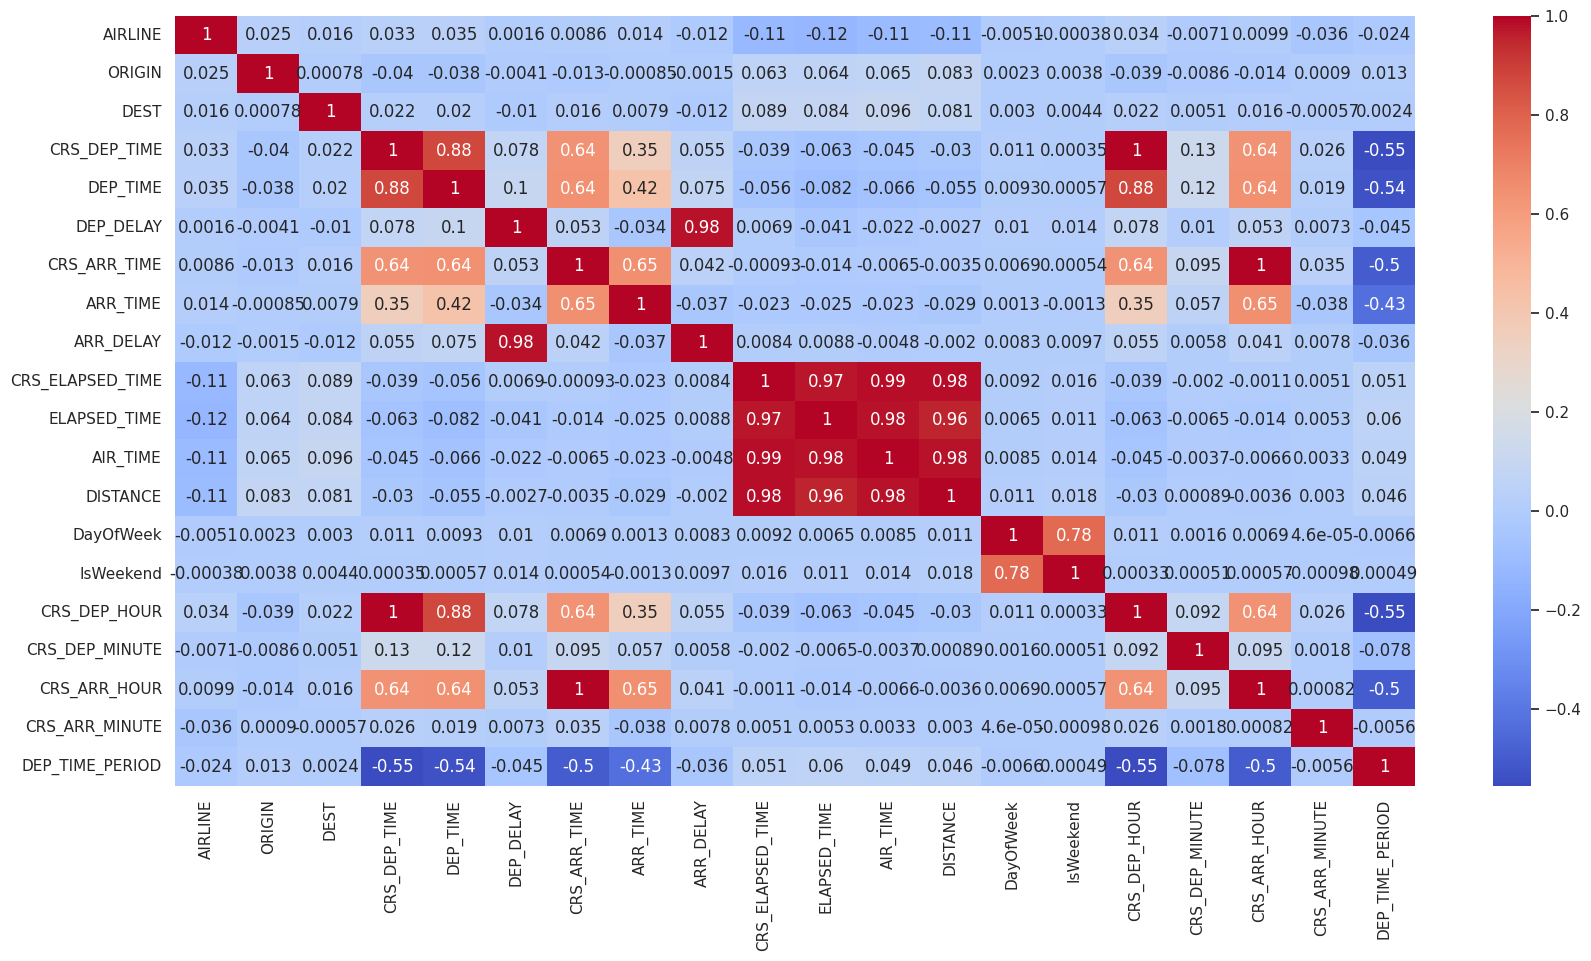

In [ ]:
# show the correlation
show_correlation(df)

In [ ]:
# split the data into features and target
# target is ARR_DELAY

X = df.drop(columns=['ARR_DELAY'])
y = df['ARR_DELAY']


In [ ]:
# Split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, shuffle=False)



In [ ]:
print(np.isnan(X_train).sum())
print(np.isinf(X_train).sum())
print(np.isnan(y_train).sum())
print(np.isinf(y_train).sum())

AIRLINE             0
ORIGIN              0
DEST                0
CRS_DEP_TIME        0
DEP_TIME            0
DEP_DELAY           0
CRS_ARR_TIME        0
ARR_TIME            0
CRS_ELAPSED_TIME    0
ELAPSED_TIME        0
AIR_TIME            0
DISTANCE            0
DayOfWeek           0
IsWeekend           0
CRS_DEP_HOUR        0
CRS_DEP_MINUTE      0
CRS_ARR_HOUR        0
CRS_ARR_MINUTE      0
DEP_TIME_PERIOD     0
dtype: int64
AIRLINE             0
ORIGIN              0
DEST                0
CRS_DEP_TIME        0
DEP_TIME            0
DEP_DELAY           0
CRS_ARR_TIME        0
ARR_TIME            0
CRS_ELAPSED_TIME    0
ELAPSED_TIME        0
AIR_TIME            0
DISTANCE            0
DayOfWeek           0
IsWeekend           0
CRS_DEP_HOUR        0
CRS_DEP_MINUTE      0
CRS_ARR_HOUR        0
CRS_ARR_MINUTE      0
DEP_TIME_PERIOD     0
dtype: int64
0
0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 21 columns):
 #   Column            Dtype         
---  ------            -----         
 0   FL_DATE           datetime64[ns]
 1   AIRLINE           int64         
 2   ORIGIN            int64         
 3   DEST              int64         
 4   CRS_DEP_TIME      int64         
 5   DEP_TIME          float64       
 6   DEP_DELAY         float64       
 7   CRS_ARR_TIME      int64         
 8   ARR_TIME          float64       
 9   ARR_DELAY         float64       
 10  CRS_ELAPSED_TIME  float64       
 11  ELAPSED_TIME      float64       
 12  AIR_TIME          float64       
 13  DISTANCE          float64       
 14  DayOfWeek         int32         
 15  IsWeekend         bool          
 16  CRS_DEP_HOUR      int64         
 17  CRS_DEP_MINUTE    int64         
 18  CRS_ARR_HOUR      int64         
 19  CRS_ARR_MINUTE    int64         
 20  DEP_TIME_PERIOD   int64         
dtypes: bool(

In [ ]:
scaler = MinMaxScaler()
df['ARR_DELAY'] = scaler.fit_transform(df[['ARR_DELAY']])

In [ ]:
print(f"After Scaling - Min delay: {df['ARR_DELAY'].min()}")
print(f"After Scaling - Max delay: {df['ARR_DELAY'].max()}")
print(f"After Scaling - Mean delay: {df['ARR_DELAY'].mean()}")
print(f"After Scaling - Standard deviation: {df['ARR_DELAY'].std()}")

After Scaling - Min delay: 0.0
After Scaling - Max delay: 0.9999999999999999
After Scaling - Mean delay: 0.013210932395861557
After Scaling - Standard deviation: 0.025848245736344214


In [ ]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Reshape y_train, y_val, and y_test into 2D arrays, scale them
y_train = y_train.values.reshape(-1, 1)  # Convert to numpy array and reshape
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)



In [ ]:
# Reshape the data for input to the LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Define the model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val),
                    verbose=2, shuffle=False, callbacks=[early_stopping])


Epoch 1/10
7489/7489 - 44s - 6ms/step - loss: 4.3260e-04 - mae: 0.0106 - val_loss: 2.7223e-05 - val_mae: 0.0033
Epoch 2/10
7489/7489 - 44s - 6ms/step - loss: 4.2567e-05 - mae: 0.0042 - val_loss: 1.2419e-05 - val_mae: 0.0018
Epoch 3/10
7489/7489 - 82s - 11ms/step - loss: 2.3623e-05 - mae: 0.0027 - val_loss: 1.0177e-05 - val_mae: 0.0013
Epoch 4/10
7489/7489 - 80s - 11ms/step - loss: 1.9342e-05 - mae: 0.0022 - val_loss: 9.2746e-06 - val_mae: 0.0011
Epoch 5/10
7489/7489 - 79s - 11ms/step - loss: 1.6657e-05 - mae: 0.0020 - val_loss: 8.5152e-06 - val_mae: 0.0010
Epoch 6/10
7489/7489 - 40s - 5ms/step - loss: 1.5715e-05 - mae: 0.0019 - val_loss: 8.3630e-06 - val_mae: 0.0012
Epoch 7/10
7489/7489 - 38s - 5ms/step - loss: 1.4392e-05 - mae: 0.0018 - val_loss: 7.5376e-06 - val_mae: 0.0010
Epoch 8/10
7489/7489 - 40s - 5ms/step - loss: 1.3792e-05 - mae: 0.0018 - val_loss: 8.5004e-06 - val_mae: 0.0015
Epoch 9/10
7489/7489 - 43s - 6ms/step - loss: 1.3128e-05 - mae: 0.0017 - val_loss: 7.0707e-06 - val_m

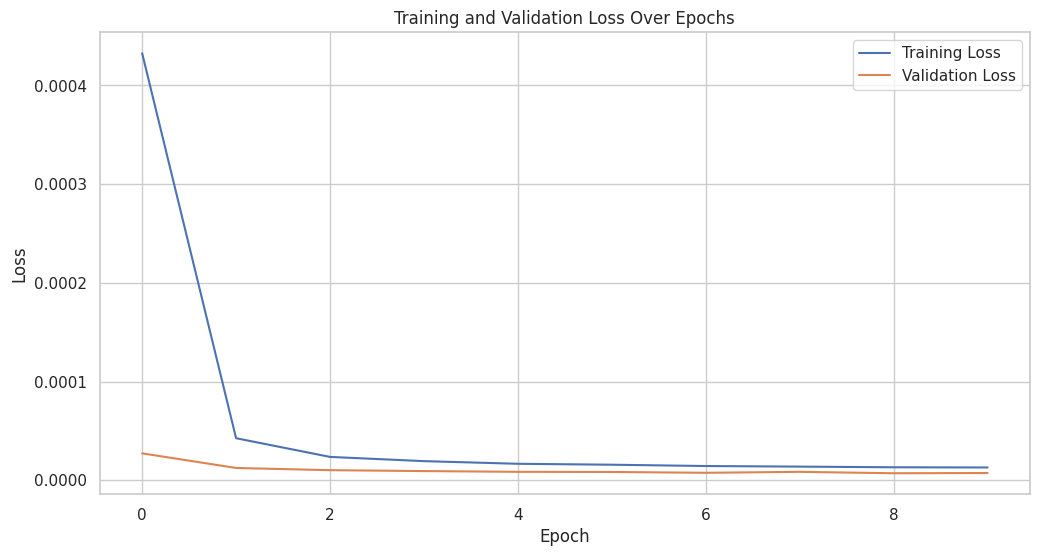

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss (MSE):', score[0])  # Mean Squared Error (MSE) as the loss
print('Test MAE:', score[1])

Test loss (MSE): 6.503763074761082e-07
Test MAE: 0.0003217758785467595


In [ ]:
mean_y = y_test.mean()
mean_y_squared = (y_test ** 2).mean()
mae_percentage = (score[1] / mean_y) * 100
mse_percentage = (score[0] / mean_y_squared) * 100

print(f"MAE Percentage: {mae_percentage:.4f}%")
print(f"MSE Percentage: {mse_percentage:.4f}%")

MAE Percentage: 2.4134%
MSE Percentage: 0.0753%


In [ ]:
y_pred = model.predict(X_test)
# Inverse transform the scaled predictions and true values
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)


9171/9171 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


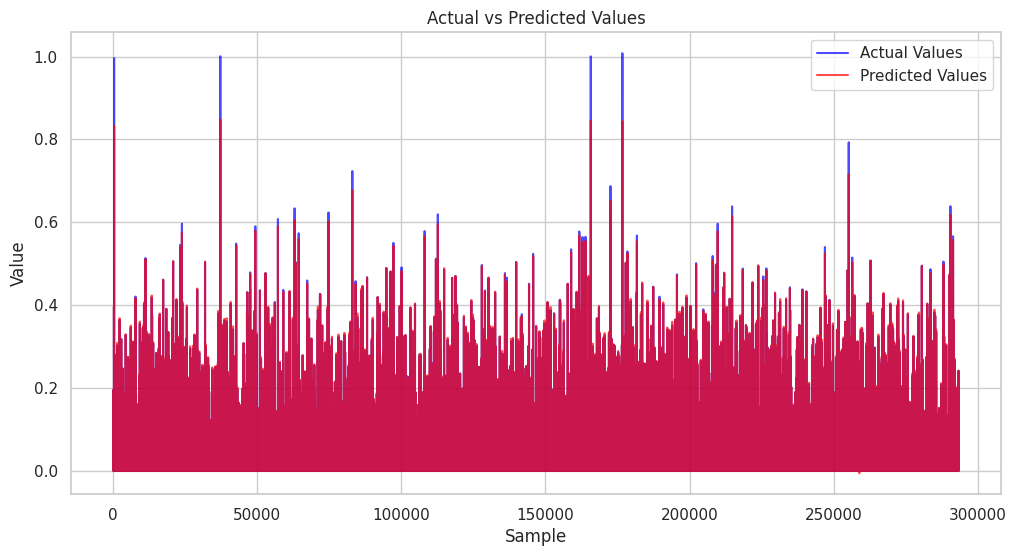

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()